In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import p2pspatial
import pulse2percept.utils as p2pu

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-04-25 17:45:37,293 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'adjust_bias': specifics['adjust_bias'],
            'best_train_cost': specifics['best_train_score'][0],
            'idx_fold': specifics['idx_fold'],
            'y_test': y,
            'y_pred': y_pred,
            'n_samples': len(y),
            'n_folds': specifics['n_folds'],
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
        data.append(row)
    return pd.DataFrame(data)

In [3]:
def calc_test_cost(grouped_data, verbose=True):
    compact_data = []
    for (subject, model, adjust_bias), data in grouped_data:
        if verbose:
            print('- Processing %s, %s %s' % (subject, model, adjust_bias))
        # Aggregate test data from all folds:
        y_test = pd.DataFrame([{'area': float(row['area']),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity']),
                                'compactness': float(row['compactness'])}
                               for row in data['y_test']], index=data.index)
        y_pred = pd.DataFrame([{'area': float(row['area']),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity']),
                                'compactness': float(row['compactness'])}
                               for row in data['y_pred']], index=data.index)
        zero = np.isclose(y_test['area'], 0)
#         y_test = y_test[np.logical_not(zero)]
#         y_pred = y_pred[np.logical_not(zero)]
        y_test['orientation'] = np.rad2deg(y_test['orientation'])
        y_pred['orientation'] = np.rad2deg(y_pred['orientation'])
        y_test['compactness'] = 1.0 / (y_test['compactness'] / (4 * np.pi))
        y_pred['compactness'] = 1.0 / (y_pred['compactness'] / (4 * np.pi))
        
        # Calculate r2:
        best_cost = 0
        r2_scores = {}
        for col in y_test.columns:
            yt = y_test.loc[:, col]
            yp = y_pred.loc[:, col]

            if col == 'orientation':
                # Use circular error:
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                # Use circular variance in `ss_tot`, which divides by len(yt).
                # Therefore, we also need to divide `ss_res` by len(yt), which
                # is the same as taking the mean instead of the sum.
                ss_res = np.mean(err ** 2)
                ss_tot = spst.circvar(yt, low=-90, high=90)
                r2_scores['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            if verbose:
                print('  - Processing %s: r2=%f' % (col, r2_scores['r2_' + col]))
            
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        compact_row = {
            'subject': subject,
            'model': model,
            'adjust_bias': adjust_bias,
            'best_test_cost': best_cost,
            'y_test': y_test,
            'y_pred': y_pred,
        }
        compact_row.update(r2_scores)
        compact_data.append(compact_row)
    return pd.DataFrame(compact_data)

In [4]:
results_dir = '../../results/shape6cv/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 167 files


In [5]:
subjects = ['TB', '12-005', '51-009', '52-001']
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [6]:
data = load_data(pickle_files, verbose=False)

In [7]:
data.columns

Index(['adjust_bias', 'best_train_cost', 'exetime', 'filename', 'filepath',
       'idx_fold', 'model', 'n_folds', 'n_samples', 'subject', 'y_pred',
       'y_test'],
      dtype='object')

# All runs

In [8]:
# Group by these:
groupcols = ['subject', 'model', 'adjust_bias']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
predcols = ['area', 'orientation', 'eccentricity', 'compactness']
r2cols = ['r2_%s' % name for name in predcols]

In [9]:
data.groupby(groupcols + ['idx_fold'], sort=False)['exetime', 'best_train_cost'].agg(['mean', 'std', 'count'])

exetime                     \
                                           mean          std count   
subject model adjust_bias idx_fold                                   
12-005  C     False       0          874.880493   368.973379     5   
                          1         1622.453928   577.183671     5   
                          2         1243.343367   515.786434     5   
                          3         1248.985731   668.557714     5   
                          4         1181.520989   314.346439     5   
                          5          944.339447   395.190808     5   
                          6         1360.602560   917.781606     5   
                          7         1166.431900   778.576188     5   
                          8         1296.745997   338.511046     5   
51-009  C     False       0         1653.645020   276.332991     2   
                          1         8116.609425          NaN     1   
                          2         8068.767351          NaN     1   
                          3         5141.527120  4090.376758     2   
                          4         3677.398838          NaN     1   
                          5         8347.210742          NaN     1   
                          6         7903.188676   181.786872     2   
                          7         2681.800361          NaN     1   
                          8         2541.108159          NaN     1   
52-001  C     False       0         2400.508031  1288.448610     5   
                          1         1723.033730   936.601204     5   
                          10        5336.640312  6779.774672     4   
                          11        5514.876920  8294.199364     4   
                          12        2055.632832   306.660275     4   
                          13        1075.600075   806.218371     4   
                          14        1987.279626   521.825934     4   
                          2         1784.051976   575.953193     5   
                          3         1579.441423   693.354896     5   
                          4         1463.885462   303.854570     5   
                          5         1869.329827  1270.963797     5   
                          6         7736.055018  7782.715586     5   
                          7         1793.152645   580.020559     5   
                          8          967.227523   498.773333     5   
                          9         1635.201851   651.731518     5   
TB      C     False       0         3992.887081  2711.886427     5   
                          1         1620.818482   864.373229     5   
                          2         2147.483633   808.333260     5   
                          3         2441.631160  1541.756147     5   
                          4         2149.878651   975.767415     5   
                          5         1533.588878   972.582445     5   
                          6         1716.298108   831.769214     5   
                          7         2108.093874   701.080195     5   

                                   best_train_cost                  
                                              mean       std count  
subject model adjust_bias idx_fold                                  
12-005  C     False       0               6.381790  0.391928     5  
                          1               5.879641  0.150458     5  
                          2               6.124580  0.188766     5  
                          3               6.799973  0.883234     5  
                          4               4.821938  0.112345     5  
                          5               9.823475  0.062926     5  
                          6               6.429905  0.618819     5  
                          7               6.440656  0.214568     5  
                          8               6.721543  0.169862     5  
51-009  C     False       0               5.294671  0.682833     2  
                          1              13.029337       NaN  

# The best runs in their respective category

In [10]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = np.isclose(data.groupby(groupcols + ['idx_fold'])['best_train_cost'].transform(np.min), 
                      data['best_train_cost'])
data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols + ['idx_fold'])['best_train_cost'].agg(['count',
                                                                                                        'min'])

Best scores:


count        min
subject model adjust_bias idx_fold                  
12-005  C     False       0             1   5.962077
                          1             1   5.785749
                          2             1   5.927492
                          3             1   6.144052
                          4             1   4.734306
                          5             1   9.744147
                          6             1   5.451529
                          7             1   6.175855
                          8             1   6.577722
51-009  C     False       0             1   4.811835
                          1             1  13.029337
                          2             1  10.643211
                          3             1  11.765144
                          4             1  25.482889
                          5             1   7.455858
                          6             1   7.780602
                          7             1  36.715950
                          8             1  14.729097
52-001  C     False       0             1   3.143056
                          1             1   3.056242
                          2             1   2.947915
                          3             1   3.192419
                          4             1   3.073894
                          5             1   2.836683
                          6             1   3.485486
                          7             1   3.174830
                          8             1   3.884972
                          9             1   3.178388
                          10            1   4.057481
                          11            1   3.364628
                          12            1   3.246338
                          13            1   3.131444
                          14            1   3.181784
TB      C     False       0             1   7.312305
                          1             1   5.391715
                          2             1   5.296752
                          3             1   5.154129
                          4             1   5.380115
                          5             1   5.752554
                          6             1   5.585194
                          7             1   6.029443

In [11]:
best = calc_test_cost(data.groupby(groupcols, sort=False), verbose=False)
best

,adjust_bias,best_test_cost,model,r2_area,r2_compactness,r2_eccentricity,r2_orientation,subject,y_pred,y_test
0,False,7.216629,C,0.051435,-1.720448,-1.789667,0.242052,12-005,area compactness eccentricity orienta...,area compactness eccentricity orienta...
1,False,2520.662473,C,-10.793335,-12.972408,-2492.662443,-0.234286,51-009,area compactness eccentricity orienta...,area compactness eccentricity orienta...
2,False,5.240289,C,-0.763767,-1.152868,0.030314,0.646032,52-001,area compactness eccentricity orien...,area compactness eccentricity orien...
3,False,7.508762,C,-1.429406,-0.607206,-2.062204,0.590053,TB,area compactness eccentricity orient...,area compactness eccentricity orient...


# Plot predictions

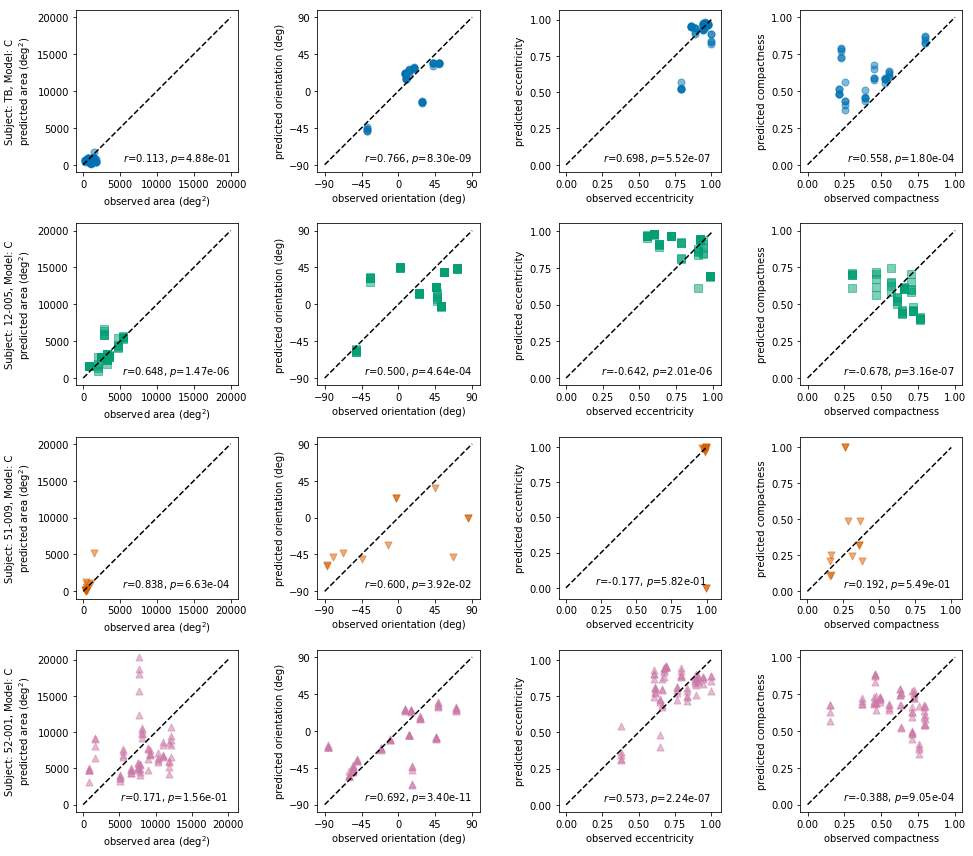

In [26]:
fig, axes = plt.subplots(ncols=len(predcols), nrows=len(subjects), 
                         figsize=(14, 3 * len(subjects)))
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
ticks = [[0, 20000], [-90, 90], [0, 1], [0, 1]]
limits = [[-2000, 22000], [-108, 108], [-0.1, 1.1], [-0.1, 1.1]]
labels = ['area (deg$^2$)', 'orientation (deg)', 'eccentricity', 'compactness']
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    for _, row in best[np.logical_and(best['subject'] == subject, best['model'] == 'C')].iterrows():
        for col, ax, tick, lim, label in zip(predcols, axrow, ticks, limits, labels):
            y = row['y_test']
            y_pred = row['y_pred']
            ax.scatter(y[col], y_pred[col], marker=marker, s=50, c=color, alpha=0.5)
            ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
            ax.set_xticks(np.linspace(*tick, num=5))
            ax.set_yticks(np.linspace(*tick, num=5))
            ax.set_xlabel('observed %s' % label)
            ax.set_ylabel('predicted %s' % label)
            ax.axis('square')
            slope, intercept, rval, pval, _ = spst.linregress(y[col], y_pred[col])
            ax.text(tick[1], tick[0], "$r$=%.3f, $p$=%.2e" % (rval, pval), va='bottom', ha='right')
    axrow[0].set_ylabel('Subject: %s, Model: %s\npredicted %s' % (row['subject'], row['model'], labels[0]))
fig.tight_layout()
fig.savefig('predict-cv.eps')